In [1]:
from collections import defaultdict
from typing import List

import os
import pandas as pd
import seaborn as sns
import re
import io

In [2]:
data_path = "../data/part4/task1"

core_list =["0", "0,1"]
num_threads = [1, 2]
num_runs=3

In [3]:
def parse_lines(file_path: str) -> List[float]:
    return 

def get_data(core_list, num_threads, num_runs):
    data = defaultdict(list)
    for core in core_list:
        for threads in num_threads:
            for run in range(num_runs):
                file_name = f"run_{run+1}/{core}_cpu_{threads}_threads.txt"
                file_path = os.path.join(data_path, file_name)
                if os.path.exists(file_path):
                    try:
                        with open(file_path, "r") as f:
                            lines = f.readlines()[2:-2] # skip first two and last two lines
                            data_str = ''.join(lines)
                            df = pd.read_csv(io.StringIO(data_str), sep='\s+')
                            data[(core, threads)].append(df)
                    except:
                        pass
                else:
                    print(f"File {file_path} does not exist.")
    return data

<>:16: SyntaxWarning: invalid escape sequence '\s'
<>:16: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_19833/2468562834.py:16: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(io.StringIO(data_str), sep='\s+')


In [4]:
data = get_data(core_list, num_threads, num_runs)

In [5]:
data[("0", 1)][0].columns

Index(['#type', 'avg', 'std', 'min', 'p5', 'p10', 'p50', 'p67', 'p75', 'p80',
       'p85', 'p90', 'p95', 'p99', 'p999', 'p9999', 'QPS', 'target',
       'ts_start', 'ts_end'],
      dtype='object')

In [6]:
def process_data(df_list, column="QPS"):

    tmp = pd.concat(df_list, axis=0)

    mean = tmp[column].groupby(tmp.index).mean()
    std = tmp[column].groupby(tmp.index).std()

    return mean, std

achieved_qps = {k: process_data(v, 'QPS') for k, v in data.items()} 
p95 = {k: process_data(v, 'p95') for k, v in data.items()}

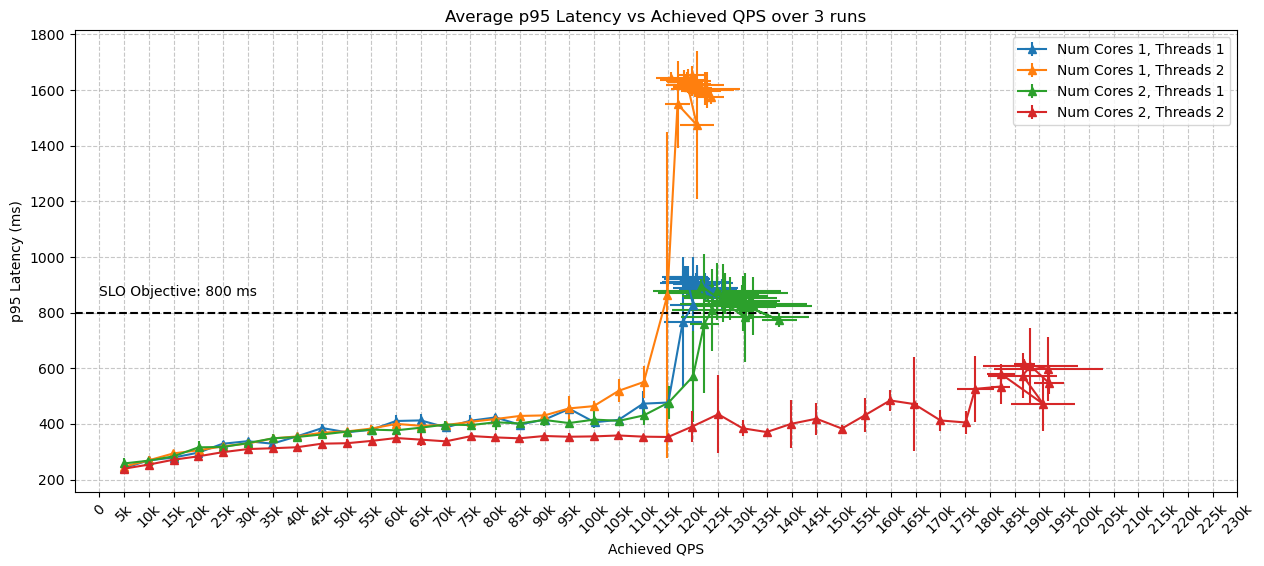

In [7]:
import matplotlib.pyplot as plt
import numpy as np

slo_latency = 800

plt.figure(figsize=(15, 6))

for k in achieved_qps.keys():
    qps_mean, qps_std = achieved_qps[k]
    p95_mean, p95_std = p95[k]

    plt.errorbar(qps_mean, p95_mean, xerr=qps_std, yerr=p95_std, label=f"Num Cores {len(k[0].split(','))}, Threads {k[1]}", marker='^', linestyle='-')

plt.axhline(y=slo_latency, color='black', linestyle='--')
plt.text(0, slo_latency + 50, f"SLO Objective: {slo_latency} ms", color='black', fontsize=10, ha='left', va='bottom')


plt.title("Average p95 Latency vs Achieved QPS over 3 runs")
#plt.suptitle("Memcached with different Number of Cores and Threads")
plt.grid(True, linestyle='--', alpha=0.7)

x_ticks = np.arange(0, 230001, 5000)

plt.xticks(x_ticks, [f"{int(x//1000)}k" if x != 0 else 0 for x in x_ticks], rotation=45)

plt.xlabel("Achieved QPS")
plt.ylabel("p95 Latency (ms)")
plt.legend()

In [8]:
def get_cpu_data(core_list, num_threads, num_runs):
    data = defaultdict(list)
    for core in core_list:
        for threads in num_threads:
            for run in range(num_runs):
                file_name = f"run_{run+1}/{core}_cpu_{threads}_threads_cpu.csv"
                file_path = os.path.join(data_path, file_name)
                if os.path.exists(file_path):
                    df = pd.read_csv(file_path, sep=',', skiprows=0)      
                    data[(core, threads)].append(df)
                else:
                    print(f"File {file_path} does not exist.")
    return data

In [9]:
cpu_data = get_cpu_data(core_list, num_threads, num_runs)

In [10]:
def get_cpu_utilization(curr, num_cpus=1):

    final_data = defaultdict(list)

    for i in range(num_runs):
        data_df = data[curr][i]
        cpu_df = cpu_data[curr][i]

        utilization = []
        for ts_start, ts_end in zip(data_df['ts_start'], data_df['ts_end']):

            # Filter the DataFrame based on the timestamp range
            # and calculate the mean CPU utilization
            cpu_utilization = cpu_df.loc[(cpu_df['timestamp'] >= ts_start * 1e6) & (cpu_df['timestamp'] <= ts_end * 1e6)].mean()
            res = cpu_utilization['core0'] + cpu_utilization['core1']
            utilization.append(res)

        final_data['utilization'].append(np.array(utilization))
        final_data['QPS'].append(data_df['QPS'].values)
        final_data['p95'].append(data_df['p95'].values)
    # Average across runs
    final_plot_data = {k: np.mean(v, axis=0) for k, v in final_data.items()}
    
    # Create figure with two y-axes
    fig, ax1 = plt.subplots(figsize=(15, 6))
    
    x_ticks = list(range(0, 230001, 5000))
    plt.xticks(x_ticks, [f"{int(i//1000)}k" if i != 0 else i for i in x_ticks], rotation=45)
    plt.xlim(0, 230000)

    # First y-axis for p95 latency
    color = 'tab:red'
    ax1.set_xlabel('QPS')
    ax1.set_ylabel('p95 Latency (ms)', color=color)
    ax1.plot(final_plot_data['QPS'], final_plot_data['p95'], 
             label="p95 Latency", marker='o', linestyle='-', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    # Add SLO line on the latency axis
    slo_latency = 800
    ax1.axhline(y=slo_latency, color='darkred', linestyle='--', alpha=0.7)
    ax1.text(final_plot_data['QPS'][0], slo_latency + 50, 
             f"SLO: {slo_latency}ms", color='darkred', fontsize=10)
    ax1.set_ylim(0, 2000)

    # Second y-axis for CPU utilization
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('CPU Utilization (%)', color=color)
    ax2.plot(final_plot_data['QPS'], final_plot_data['utilization'], 
             label="CPU Utilization", marker='s', linestyle='--', color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    
    # Set y-axis range for CPU utilization (0-100%)
    ax2.set_ylim(0, 100*num_cpus+10)
    
    
    # Add title and grid
    plt.title(f"Performance Metrics vs QPS (Num Cores: {len(curr[0].split(','))}, Threads: {curr[1]})")
    ax1.grid(True, linestyle='--', alpha=0.3)
    
    # Add combined legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
        
    plt.show()

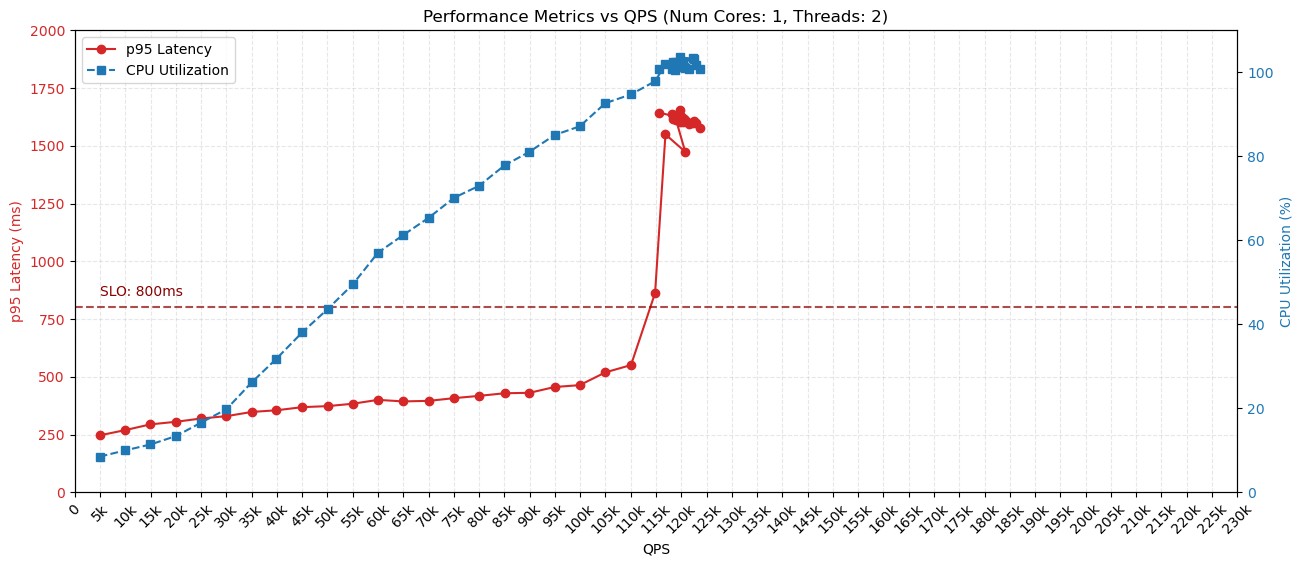

In [11]:
get_cpu_utilization(("0", 2), 1)

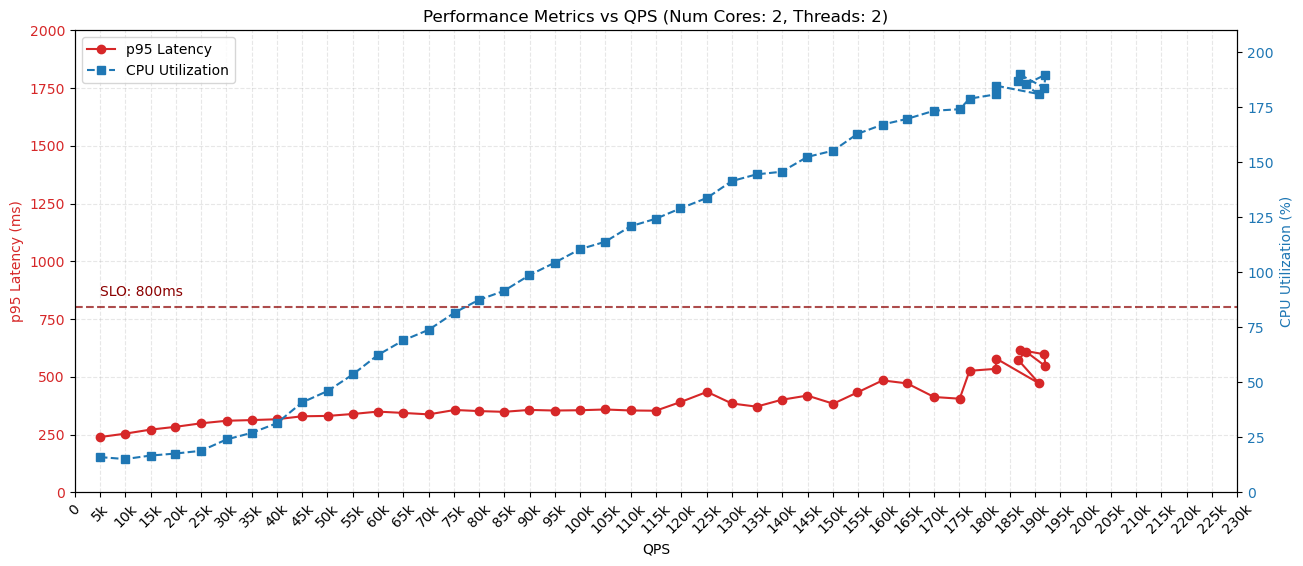

In [12]:
get_cpu_utilization(("0,1", 2), 2)